In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

# 1. Cleaning Data

### Member Hold Times Table

In [3]:
# load in raw members data
members_raw = pd.read_csv(r'data/member_hold_times_and_packs.tsv', sep='\t', header=None, names=["member", 'hold_time', 'pack_name'])

In [4]:
# view raw data
members_raw.head()

,member,hold_time,pack_name
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...
1,member1,0.998885,DaVici Puzzles Full Moon Feast DaVici Puzzles ...
2,member1,10.865032,DaVici Puzzles Flying Frigate DaVici Puzzles H...
3,member1,22.083971,Liberty Puzzles Haeckel Hummingbirds Nautilus ...
4,member1,5.077603,DaVici Puzzles Diana Zimens City Of Cats


In [5]:
# check for null values in table
members_raw.isna().sum()

member       0
hold_time    0
pack_name    0
dtype: int64

In [6]:
# get more summary metrics about the table
members_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18141 entries, 0 to 18140
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member     18141 non-null  object 
 1   hold_time  18141 non-null  float64
 2   pack_name  18141 non-null  object 
dtypes: float64(1), object(2)
memory usage: 425.3+ KB


In [7]:
# look at the summary metrics for hold times
members_raw.describe()

,hold_time
count,18141.000000
mean,18.376564
std,31.868589
min,0.000157
25%,4.736597
50%,9.765611
75%,19.684449
max,589.189204


<AxesSubplot:ylabel='Frequency'>

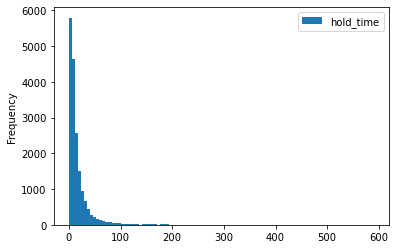

In [8]:
# look at the distribution of hold times
members_raw.plot(kind = "hist", bins = 100)

In [9]:
# count how many puzzles pack information each member has
count_puzzles_per_member = members_raw['member'].value_counts()

<AxesSubplot:ylabel='Frequency'>

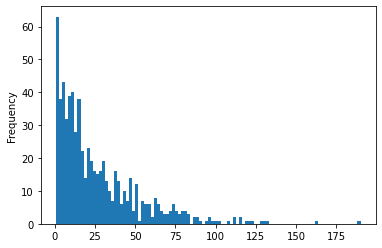

In [10]:
# plot a histogram to display the distribution of puzzle packs per member
count_puzzles_per_member.plot(kind = "hist", bins = 100)

In [11]:
# count how much hold time/member data each puzzle pack has
count_members_per_puzzle = members_raw['pack_name'].value_counts()

<AxesSubplot:ylabel='Frequency'>

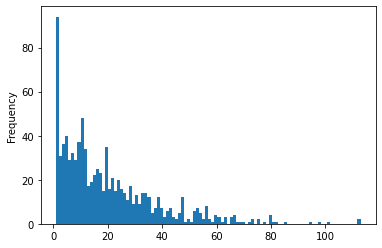

In [12]:
# plot a histogram to display the distribution of hold time data per puzzle pack
count_members_per_puzzle.plot(kind = "hist", bins = 100)

##### Handling Outliers
Per Maya's Email: Hold times are measured from when the post office's tracking system thinks the pack was delivered until when the member used our software to say that they're done with the pack. There are several ways these hold-time values can be noisy. For example, if the hold time is less than 0.1, it's an artifact of a database fix and you should just remove it!  Very long hold-times (over 200 days) might be real or might be noisy, but are probably noisy. Consider some outlier removal in both directions. 

We can probably do more exploration on how we should deal with hold times > 200 because Maya mentioned this is just noisy data. We can explore bootstrapping/resampling, imputing mean hold times on the puzzle level, etc. 

In [13]:
# count how many hold times are <0.1
len(members_raw.loc[members_raw['hold_time'] < 0.1])

100

In [14]:
# count how many hold times are >200
len(members_raw.loc[members_raw['hold_time'] > 200])

114

In [15]:
# remove outliers
members = members_raw[(members_raw.hold_time > 0.1) & (members_raw.hold_time < 200)]

In [16]:
# recalculate summary metrics for hold times after removing outliers
members.describe()

,hold_time
count,17927.000000
mean,16.698441
std,22.020143
min,0.100739
25%,4.764014
50%,9.756276
75%,19.332344
max,199.812165


**Comment**: Even after removing these outliers, there is still significant skew in hold times, distribution of puzzle packs per member, and distribution of members per puzzle pack....

In [17]:
members.to_csv(r'data/members_cleaned.csv')

### Packs Table

In [18]:
# load in raw packs data
packs_raw = pd.read_csv(r'data/packs_Jan14_better.tsv', sep='\t', header=None, names=["pack_name", 'brand_all', 'piece_count_all', 'difficulty_all'])

In [19]:
# view raw data
packs_raw.head()

,pack_name,brand_all,piece_count_all,difficulty_all
0,Anne Belle Thompson The Mikado Anne Belle Thom...,Other-Hand-cut,"387,242","Average,Average"
1,Anthology Puzzles Alphonse Mucha La Plume Anth...,NaN,"320,160","Average,Average"
2,Anthology Puzzles Colorful Cat Anthology Puzzl...,NaN,"150,170","Average,Average"
3,Anthology Puzzles Framed American Gothic Antho...,NaN,"320,300","Average,Average"
4,Anthology Puzzles Over The Moon Anthology Puzz...,NaN,"278,177","Hard,A-Easy"


In [20]:
# split brands
brands_split = packs_raw['brand_all'].str.split(',', n=1, expand=True).rename(columns={0:'brand_0', 1:'brand_1'})
brands_split.head()

,brand_0,brand_1
0,Other-Hand-cut,None
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [21]:
# split pieces
pieces_split = packs_raw['piece_count_all'].str.split(',', n=1, expand=True).rename(columns={0:'pieces_0', 1:'pieces_1'})
pieces_split.head()

,pieces_0,pieces_1
0,387,242
1,320,160
2,150,170
3,320,300
4,278,177


In [22]:
# split difficulty
diff_split = packs_raw['difficulty_all'].str.split(',', n=1, expand=True).rename(columns={0:'diff_0', 1:'diff_1'})
diff_split.head()

,diff_0,diff_1
0,Average,Average
1,Average,Average
2,Average,Average
3,Average,Average
4,Hard,A-Easy


In [23]:
# join the split brands, piece, and difficulties
# count number of puzzles in pack based on if there are two piece counts in the pack
packs_joined = packs_raw.join([brands_split, pieces_split, diff_split])
packs_joined['num_puzzles'] = np.where(packs_raw['piece_count_all'].isna(), np.nan, np.where(packs_raw['piece_count_all'].str.contains(','), 2, 1))
packs_joined.head()

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles
0,Anne Belle Thompson The Mikado Anne Belle Thom...,Other-Hand-cut,"387,242","Average,Average",Other-Hand-cut,None,387,242,Average,Average,2.0
1,Anthology Puzzles Alphonse Mucha La Plume Anth...,NaN,"320,160","Average,Average",NaN,NaN,320,160,Average,Average,2.0
2,Anthology Puzzles Colorful Cat Anthology Puzzl...,NaN,"150,170","Average,Average",NaN,NaN,150,170,Average,Average,2.0
3,Anthology Puzzles Framed American Gothic Antho...,NaN,"320,300","Average,Average",NaN,NaN,320,300,Average,Average,2.0
4,Anthology Puzzles Over The Moon Anthology Puzz...,NaN,"278,177","Hard,A-Easy",NaN,NaN,278,177,Hard,A-Easy,2.0


##### Handling missing Piece Count and Difficulty information
Per Maya's email: I'd impute based on average for the same brand and binned piece count. Or if that's too hard, okay to just impute with the global average. 

In [24]:
# check for rows that have no piece count information but have brand information
packs_joined[packs_joined['piece_count_all'].isna() & (~packs_joined['brand_all'].isna())]

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles
441,Unidragon Cappadocia Quezzle,Other-Laser-cut,NaN,"A-Easy,Average",Other-Laser-cut,None,NaN,NaN,A-Easy,Average,NaN
515,Wentworth Puzzles Paula Doherty Nativity Kings,Wentworth,NaN,"Hard,Average",Wentworth,None,NaN,NaN,Hard,Average,NaN


**Comment**: For these 2 rows above with no piece count information, we can impute the value based on the average piece count grouped by brand and binned by difficulty (per Maya's advice) <br />
To calculate the average piece counts, I looked at the first brand name and the first difficulty rating of the pack, parsed through instances in the existing dataframe that matched the brand name and difficulty rating (on both brand and difficulty columns) and then calculated the average piece count. I then did the same thing for the second brand name and second difficulty rating on these rows. Since there was no second brand name for either of these puzzles, but there was a second difficulty rating listed, I assumed that these packs had 2 puzzles and just took the average piece count of all Null brands with the corresponding difficulty rating listed above. <br />
I'm not sure if this is the correct way to approach this, but we should probably have a discussion about this

In [25]:
# calculates the average number of pieces based on given brand name and difficulty
# if brand name input is an empty string, function will assume that brand name is null
def calc_avg_piece_count(brand_name, difficulty):
    if brand_name == '':
        piece_0 = np.asarray(packs_joined.loc[(packs_joined['brand_0'].isna()) & 
                                   (packs_joined['diff_0'] == difficulty) & 
                                   (~packs_joined['pieces_0'].isna()), 'pieces_0'].values, dtype='int')
        piece_1 = np.asarray(packs_joined.loc[(packs_joined['brand_1'].isna()) & 
                                   (packs_joined['diff_1'] == difficulty) & 
                                   (~packs_joined['pieces_1'].isna()), 'pieces_1'].values, dtype='int')
        
    else:
        piece_0 = np.asarray(packs_joined.loc[(packs_joined['brand_0'] == brand_name) & 
                                   (packs_joined['diff_0'] == difficulty) & 
                                   (~packs_joined['pieces_0'].isna()), 'pieces_0'].values, dtype='int')
        piece_1 = np.asarray(packs_joined.loc[(packs_joined['brand_1'] == brand_name) & 
                                   (packs_joined['diff_1'] == difficulty) & 
                                   (~packs_joined['pieces_1'].isna()), 'pieces_1'].values, dtype='int')
    return round(np.mean(np.concatenate((piece_0,piece_1))))

In [26]:
# impute average piece count values to the two rows above
packs_joined.loc[packs_joined['pack_name'] == 'Unidragon Cappadocia Quezzle ', 'pieces_0'] = calc_avg_piece_count('Other-Laser-cut', 'A-Easy')
packs_joined.loc[packs_joined['pack_name'] == 'Unidragon Cappadocia Quezzle ', 'pieces_1'] = calc_avg_piece_count('', 'Average')
packs_joined.loc[packs_joined['pack_name'] == 'Wentworth Puzzles Paula Doherty Nativity Kings ', 'pieces_0'] = calc_avg_piece_count('Wentworth', 'Hard')
packs_joined.loc[packs_joined['pack_name'] == 'Wentworth Puzzles Paula Doherty Nativity Kings ', 'pieces_1'] = calc_avg_piece_count('', 'Average')

# impute num_puzzle = 2 for both puzzles above (based on assumption)
packs_joined.loc[packs_joined['pack_name'] == 'Unidragon Cappadocia Quezzle ', 'num_puzzles'] = 2
packs_joined.loc[packs_joined['pack_name'] == 'Wentworth Puzzles Paula Doherty Nativity Kings ', 'num_puzzles'] = 2

In [27]:
# validate that the pieces were imputed properly
packs_joined[packs_joined['piece_count_all'].isna() & (~packs_joined['brand_all'].isna())]

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles
441,Unidragon Cappadocia Quezzle,Other-Laser-cut,NaN,"A-Easy,Average",Other-Laser-cut,None,259,322,A-Easy,Average,2.0
515,Wentworth Puzzles Paula Doherty Nativity Kings,Wentworth,NaN,"Hard,Average",Wentworth,None,628,322,Hard,Average,2.0


In [28]:
# check for rows that have no difficulty information but have brand information
packs_joined[packs_joined['difficulty_all'].isna() & (~packs_joined['brand_all'].isna())]

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles


In [29]:
# check for rows that have no piece count, difficulty, or brand name
packs_joined[packs_joined['piece_count_all'].isna() & 
            (packs_joined['difficulty_all'].isna()) & 
            (packs_joined['brand_all'].isna())]

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles
30,Artifact Puzzles Kozyndan Ode To California Ar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Artifact Puzzles Kristian Adam Chippy Artifact...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Artifact Puzzles Kristian Adam Chippy Artifact...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,Artifact Puzzles Nadieh Bremer Coronium Artifa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,BellArt Puzzles Double-sided Angel Maze Fish E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
433,Stave Puzzles Susan Greenleaf What A Dive! Cre...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,Waterford Puzzles Merry Kohn Buvia From Around...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,Wentworth Puzzles Celebrate Life Gallery The P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,Wentworth Puzzles Sailing To The Tunes Wentwor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Comment**: For the 80 rows above with no information on brand, piece count, or difficulty ratings, we can impute the global average for piece count and difficulty rating. 
This isn't a perfect solution, especially since we don't have information on whether these packs contain 1 or 2 puzzles. As a temporary solution, I'm just going to assume that these have just 1 puzzle and impute the global average of piece count and difficulty rating into the first column of the respective features. This is something we'll likely have to discuss with Maya later. 

In [30]:
# calculate the global average for piece count
pieces_0 = np.asarray(packs_joined.loc[~packs_joined['pieces_0'].isna(), 'pieces_0'].values, dtype='int')
pieces_1 = np.asarray(packs_joined.loc[~packs_joined['pieces_1'].isna(), 'pieces_1'].values, dtype='int')
pieces_global_avg = round(np.mean(np.concatenate((pieces_0,pieces_1))))

In [31]:
# map difficulty ratings into a numeric value
difficulty_mapping = {'A-Easy': 1, 'Average': 2, 'Hard': 3, 'Really-Hard': 4}
packs_joined['diff_0_num'] = packs_joined['diff_0'].map(lambda x: difficulty_mapping[x], na_action='ignore')
packs_joined['diff_1_num'] = packs_joined['diff_1'].map(lambda x: difficulty_mapping[x], na_action='ignore')

In [32]:
# calculate the global average for difficulty rating
diff_0 = np.asarray(packs_joined.loc[~packs_joined['diff_0_num'].isna(), 'diff_0_num'].values, dtype='int')
diff_1 = np.asarray(packs_joined.loc[~packs_joined['diff_1_num'].isna(), 'diff_1_num'].values, dtype='int')
diff_global_avg = round(np.mean(np.concatenate((diff_0,diff_1))))

In [33]:
# impute global avg values to the rows with no piece count, difficulty, or brand name
packs_joined.loc[(packs_joined['piece_count_all'].isna() & 
                 (packs_joined['difficulty_all'].isna()) & 
                 (packs_joined['brand_all'].isna())),'pieces_0'] = pieces_global_avg
packs_joined.loc[(packs_joined['piece_count_all'].isna() & 
                 (packs_joined['difficulty_all'].isna()) & 
                 (packs_joined['brand_all'].isna())),'diff_0_num'] = diff_global_avg

# impute num_puzzle = 1 for all puzzles with no piece count, difficulty, or brand (based on assumption)
packs_joined.loc[(packs_joined['piece_count_all'].isna() & 
                 (packs_joined['difficulty_all'].isna()) & 
                 (packs_joined['brand_all'].isna())),'num_puzzles'] = 1

In [34]:
# validate that the global avg for piece & difficulty were imputed properly
packs_joined[packs_joined['piece_count_all'].isna() & 
            (packs_joined['difficulty_all'].isna()) & 
            (packs_joined['brand_all'].isna())].head()

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles,diff_0_num,diff_1_num
30,Artifact Puzzles Kozyndan Ode To California Ar...,NaN,NaN,NaN,NaN,NaN,361,NaN,NaN,NaN,1.0,2.0,NaN
31,Artifact Puzzles Kristian Adam Chippy Artifact...,NaN,NaN,NaN,NaN,NaN,361,NaN,NaN,NaN,1.0,2.0,NaN
32,Artifact Puzzles Kristian Adam Chippy Artifact...,NaN,NaN,NaN,NaN,NaN,361,NaN,NaN,NaN,1.0,2.0,NaN
38,Artifact Puzzles Nadieh Bremer Coronium Artifa...,NaN,NaN,NaN,NaN,NaN,361,NaN,NaN,NaN,1.0,2.0,NaN
59,BellArt Puzzles Double-sided Angel Maze Fish E...,NaN,NaN,NaN,NaN,NaN,361,NaN,NaN,NaN,1.0,2.0,NaN


##### Handling mismatched rows that have 2 brands or 2 difficulties but one piece count value
There's approximately 157 rows where there are either 2 brands listed or 2 difficulties listed but only 1 piece count value (i.e. num_puzzles = 1). I wasn't sure exactly how we should handle these instances, but I just went ahead with the assumption that these should only have 1 puzzle (based on what Maya said that if there are 2 piece counts, it's safe to assume that it's a pack with 2 puzzles). For these instances, I am going to impute the 2nd brand or 2nd difficulty listed as Null. I'm mainly doing this to maintain consistency; we may not actually need to do this. We should also get some more guidance and clarification on the best way to handle this.

In [35]:
# check for rows that have only 1 puzzle, but has a second brand or difficulty rating listed
packs_joined[packs_joined['num_puzzles']==1 & 
            ((~packs_joined['diff_1'].isna())|(~packs_joined['brand_1'].isna()))]

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles,diff_0_num,diff_1_num
10,Artifact Puzzles Bek Cruddace Europe Map,Artifact,900,"Average,Average",Artifact,None,900,None,Average,Average,1.0,2.0,2.0
46,Artifact Puzzles Sandi Rigby Botanical Dreaming,Artifact,1273,"Hard,Average",Artifact,None,1273,None,Hard,Average,1.0,3.0,2.0
90,DaVici Puzzles Under the Red Umbrella,DaVici,600,"Hard,Average",DaVici,None,600,None,Hard,Average,1.0,3.0,2.0
92,DaVici Red Book,DaVici,700,"Hard,Average",DaVici,None,700,None,Hard,Average,1.0,3.0,2.0
95,Davici Puzzles Claude Monet Woman in the Garden,DaVici,552,"A-Easy,Average",DaVici,None,552,None,A-Easy,Average,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,Artifact Puzzles Bokuyo Forest,Artifact,689,"Really-Hard,Average",Artifact,None,689,None,Really-Hard,Average,1.0,4.0,2.0
808,Artifact Puzzles Hieronymus Bosch Garden Of Ea...,Artifact,529,"Average,Average",Artifact,None,529,None,Average,Average,1.0,2.0,2.0
864,DaVici Puzzles Diana Zimens City Of Cats,DaVici,700,"Average,Average",DaVici,None,700,None,Average,Average,1.0,2.0,2.0
868,Artifact Puzzles Jethro Buck Wild Things,Artifact,539,"Hard,Average",Artifact,None,539,None,Hard,Average,1.0,3.0,2.0


In [36]:
# impute a null value for the second brand name and second difficulty rating in cases where there is only 1 puzzle
packs_joined.loc[packs_joined['num_puzzles']==1 & 
                 ((~packs_joined['diff_1'].isna())|(~packs_joined['brand_1'].isna())),'diff_1_num'] = np.nan
packs_joined.loc[packs_joined['num_puzzles']==1 & 
                 ((~packs_joined['diff_1'].isna())|(~packs_joined['brand_1'].isna())),'diff_1'] = np.nan
packs_joined.loc[packs_joined['num_puzzles']==1 & 
                 ((~packs_joined['diff_1'].isna())|(~packs_joined['brand_1'].isna())),'brand_1'] = np.nan

In [37]:
# validate that the null values for the second brand name and second difficulty were imputed properly
# (this should return a blank result)
packs_joined[packs_joined['num_puzzles']==1 & 
            ((~packs_joined['diff_1'].isna())|(~packs_joined['brand_1'].isna()))]

,pack_name,brand_all,piece_count_all,difficulty_all,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles,diff_0_num,diff_1_num


##### Some additional cleaning

In [38]:
# drop the original columns with all/combined information
packs_joined = packs_joined.drop(['brand_all', 'piece_count_all', 'difficulty_all'], axis=1)
packs_joined.head()

,pack_name,brand_0,brand_1,pieces_0,pieces_1,diff_0,diff_1,num_puzzles,diff_0_num,diff_1_num
0,Anne Belle Thompson The Mikado Anne Belle Thom...,Other-Hand-cut,None,387,242,Average,Average,2.0,2.0,2.0
1,Anthology Puzzles Alphonse Mucha La Plume Anth...,NaN,NaN,320,160,Average,Average,2.0,2.0,2.0
2,Anthology Puzzles Colorful Cat Anthology Puzzl...,NaN,NaN,150,170,Average,Average,2.0,2.0,2.0
3,Anthology Puzzles Framed American Gothic Antho...,NaN,NaN,320,300,Average,Average,2.0,2.0,2.0
4,Anthology Puzzles Over The Moon Anthology Puzz...,NaN,NaN,278,177,Hard,A-Easy,2.0,3.0,1.0


In [39]:
# convert pieces columns to floats
packs_joined['pieces_1'].fillna(-1, inplace = True)
packs_joined = packs_joined.astype({'pieces_0': 'float64', 'pieces_1': 'float64'}, errors='ignore')
packs_joined['pieces_1'] = packs_joined['pieces_1'].replace(-1,np.nan)

In [40]:
# calculate how many null values per column
packs_joined.isna().sum()

pack_name        0
brand_0        108
brand_1        801
pieces_0         0
pieces_1       239
diff_0          80
diff_1         239
num_puzzles      0
diff_0_num       0
diff_1_num     239
dtype: int64

In [41]:
# get more summary metrics about the table
packs_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pack_name    909 non-null    object 
 1   brand_0      801 non-null    object 
 2   brand_1      108 non-null    object 
 3   pieces_0     909 non-null    float64
 4   pieces_1     670 non-null    float64
 5   diff_0       829 non-null    object 
 6   diff_1       670 non-null    object 
 7   num_puzzles  909 non-null    float64
 8   diff_0_num   909 non-null    float64
 9   diff_1_num   670 non-null    float64
dtypes: float64(5), object(5)
memory usage: 71.1+ KB


In [42]:
# look at summary metrics for numeric columns
packs_joined.describe()

,pieces_0,pieces_1,num_puzzles,diff_0_num,diff_1_num
count,909.000000,670.000000,909.000000,909.000000,670.000000
mean,398.070407,310.882090,1.737074,2.062706,1.982090
std,220.850692,140.847816,0.440465,0.754886,0.797778
min,35.000000,30.000000,1.000000,1.000000,1.000000
25%,250.000000,203.250000,1.000000,2.000000,1.000000
50%,361.000000,292.500000,2.000000,2.000000,2.000000
75%,500.000000,405.000000,2.000000,2.000000,2.000000
max,1500.000000,1000.000000,2.000000,4.000000,4.000000


In [45]:
packs_joined.to_csv(r'data/packs_cleaned.csv')

# 2. Joining Tables

In [46]:
# encode number of pieces into columns mapped by difficulty
pieces_by_difficulty = []

for i, row in packs_joined.iterrows():
    out = {
        'pack_name': row['pack_name'],
        'pieces_d1': 0,
        'pieces_d2': 0,
        'pieces_d3': 0,
        'pieces_d4': 0,
        'num_puzzles': row['num_puzzles']
    }
    
    out[f'pieces_d{str(int(row["diff_0_num"]))}'] = row['pieces_0']
    
    if(row['num_puzzles'] == 2):
        out[f'pieces_d{str(int(row["diff_1_num"]))}'] += row['pieces_1']
        
    pieces_by_difficulty.append(out)

In [47]:
pbyd = pd.DataFrame(pieces_by_difficulty)
pbyd.head()

,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles
0,Anne Belle Thompson The Mikado Anne Belle Thom...,0.0,629.0,0.0,0.0,2.0
1,Anthology Puzzles Alphonse Mucha La Plume Anth...,0.0,480.0,0.0,0.0,2.0
2,Anthology Puzzles Colorful Cat Anthology Puzzl...,0.0,320.0,0.0,0.0,2.0
3,Anthology Puzzles Framed American Gothic Antho...,0.0,620.0,0.0,0.0,2.0
4,Anthology Puzzles Over The Moon Anthology Puzz...,177.0,0.0,278.0,0.0,2.0


**Comment**: I'm going to try combining difficulty and piece count into a single column value here.<br />
My approach is super simplistic, essentially I'm weighting Easy: 1, Average: 2, Hard: 3, Really-Hard: 4. We can probably work on improving this later on, but I'm mainly curious to see how the model will perform if we use average hold time based on binned piece count & difficulty

In [48]:
pbyd['w_pieces_diff'] = pbyd['pieces_d1'] + pbyd['pieces_d2']*2 + pbyd['pieces_d3']*3 + pbyd['pieces_d4']*4
pbyd.head()

,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,w_pieces_diff
0,Anne Belle Thompson The Mikado Anne Belle Thom...,0.0,629.0,0.0,0.0,2.0,1258.0
1,Anthology Puzzles Alphonse Mucha La Plume Anth...,0.0,480.0,0.0,0.0,2.0,960.0
2,Anthology Puzzles Colorful Cat Anthology Puzzl...,0.0,320.0,0.0,0.0,2.0,640.0
3,Anthology Puzzles Framed American Gothic Antho...,0.0,620.0,0.0,0.0,2.0,1240.0
4,Anthology Puzzles Over The Moon Anthology Puzz...,177.0,0.0,278.0,0.0,2.0,1011.0


<AxesSubplot:xlabel='w_pieces_diff', ylabel='Count'>

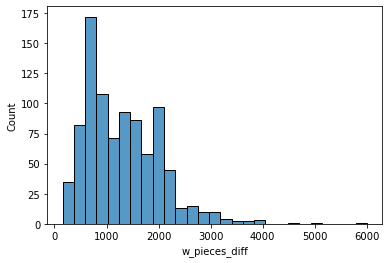

In [49]:
# look at the distribution of weighted piece difficulty
sns.histplot(pbyd['w_pieces_diff'])

<AxesSubplot:xlabel='w_pieces_diff_transformed', ylabel='Count'>

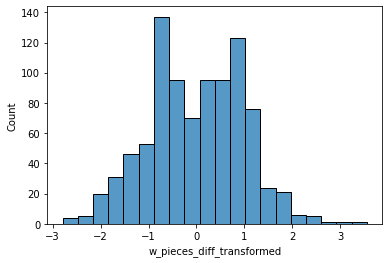

In [50]:
# use box cox method to transform weighted pieces by difficulty
from sklearn.preprocessing import power_transform 
pbyd['w_pieces_diff_transformed'] = power_transform(pbyd[['w_pieces_diff']], method='box-cox')

# look at the new distribution of this transformed feature
sns.histplot(pbyd['w_pieces_diff_transformed'])

In [51]:
# creat list of bin names and label names
# I just picked an arbitrary number of 20 bins, to group the piece difficulty by, this can be improved on
step = (pbyd['w_pieces_diff_transformed'].max()-pbyd['w_pieces_diff_transformed'].min())/20
bins = np.arange(pbyd['w_pieces_diff_transformed'].min(), pbyd['w_pieces_diff_transformed'].max()+step, step)
labels = ['bin' + s for s in map(str, list(range(len(bins)-1)))]

# label each puzzle by binned piece & difficulty
pbyd['bin_label'] = pd.cut(x = pbyd['w_pieces_diff_transformed'], bins = bins, labels = labels, include_lowest = True)
pbyd.head()

,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,w_pieces_diff,w_pieces_diff_transformed,bin_label
0,Anne Belle Thompson The Mikado Anne Belle Thom...,0.0,629.0,0.0,0.0,2.0,1258.0,0.129889,bin9
1,Anthology Puzzles Alphonse Mucha La Plume Anth...,0.0,480.0,0.0,0.0,2.0,960.0,-0.339134,bin7
2,Anthology Puzzles Colorful Cat Anthology Puzzl...,0.0,320.0,0.0,0.0,2.0,640.0,-0.985748,bin5
3,Anthology Puzzles Framed American Gothic Antho...,0.0,620.0,0.0,0.0,2.0,1240.0,0.104078,bin9
4,Anthology Puzzles Over The Moon Anthology Puzz...,177.0,0.0,278.0,0.0,2.0,1011.0,-0.251769,bin8


In [52]:
# join member information with puzzle pack information
joined_df = members.merge(pbyd, left_on='pack_name', right_on='pack_name', how='left')
joined_df.head()

,member,hold_time,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,w_pieces_diff,w_pieces_diff_transformed,bin_label
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...,456.0,548.0,0.0,0.0,2.0,1552.0,0.516776,bin10
1,member1,0.998885,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,0.0,0.0,415.0,0.0,2.0,1245.0,0.111276,bin9
2,member1,10.865032,DaVici Puzzles Flying Frigate DaVici Puzzles H...,295.0,0.0,0.0,0.0,2.0,295.0,-2.052702,bin2
3,member1,22.083971,Liberty Puzzles Haeckel Hummingbirds Nautilus ...,0.0,707.0,0.0,0.0,2.0,1414.0,0.342724,bin9
4,member1,5.077603,DaVici Puzzles Diana Zimens City Of Cats,0.0,700.0,0.0,0.0,1.0,1400.0,0.324365,bin9


**Comment**: I realized here that when we join the members table with packs, there are a lot of packs from the members table that are not on the packs table. Because of this, I'm going to remove instances where there is no pack information tied to the member since I can't really calculate the rolling average hold time by weighted piece count and difficulty bins for these instances. This makes up 1047 rows of member data lost. <br />
We should definitely talk to Maya about how to approach these data points that don't have matching pack information to the member.

In [53]:
# count how many rows of members don't have any packs information
sum(joined_df['w_pieces_diff'].isna())

1047

In [54]:
# remove rows where there is no pack information for members
df = joined_df[~joined_df['w_pieces_diff'].isna()].reset_index(drop=True)
df.head()

,member,hold_time,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,w_pieces_diff,w_pieces_diff_transformed,bin_label
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...,456.0,548.0,0.0,0.0,2.0,1552.0,0.516776,bin10
1,member1,0.998885,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,0.0,0.0,415.0,0.0,2.0,1245.0,0.111276,bin9
2,member1,10.865032,DaVici Puzzles Flying Frigate DaVici Puzzles H...,295.0,0.0,0.0,0.0,2.0,295.0,-2.052702,bin2
3,member1,22.083971,Liberty Puzzles Haeckel Hummingbirds Nautilus ...,0.0,707.0,0.0,0.0,2.0,1414.0,0.342724,bin9
4,member1,5.077603,DaVici Puzzles Diana Zimens City Of Cats,0.0,700.0,0.0,0.0,1.0,1400.0,0.324365,bin9


In [55]:
df.to_csv(r'data/joined_cleaned.csv')

# 4. Building & Evaluating Models

In [56]:
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

In [57]:
#Linear Regression with k fold cross validation

X = df
# add rolling average hold time by member to training set
X['last_hold_time'] = X.groupby('member')['hold_time'].shift(1, fill_value = 7)
X['avg_hold_time'] = X.groupby('member')['last_hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)
    
# add rolling average hold time by pack to training set
X['avg_hold_time_for_puzzle'] = X.groupby('pack_name')['hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)

# add rolling average hold time by binned piece count + difficulty to training set
X['last_bin_hold_time'] = X.groupby('bin_label')['hold_time'].shift(1, fill_value = 7)
avg_hold_time_piece_diff = pd.DataFrame(X.groupby('bin_label')['last_bin_hold_time'].transform(lambda x: x.rolling(5,1).mean())).rename(columns={'last_bin_hold_time': 'avg_hold_time_piece_diff'})
X = pd.merge(X, avg_hold_time_piece_diff, left_index=True, right_index=True)

y = X['hold_time']
X = X.drop(['member', 'hold_time', 'pack_name', 'w_pieces_diff', 'bin_label', 'last_hold_time', 'last_bin_hold_time'], axis=1)

# Linear Regression Model
lin = linear_model.LinearRegression()

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(lin, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [58]:
np.mean(np.absolute(scores))

9.906698971562124

In [59]:
#Lasso Regression with k fold cross validation

X = df
# add rolling average hold time by member to training set
X['last_hold_time'] = X.groupby('member')['hold_time'].shift(1, fill_value = 7)
X['avg_hold_time'] = X.groupby('member')['last_hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)
    
# add rolling average hold time by pack to training set
X['avg_hold_time_for_puzzle'] = X.groupby('pack_name')['hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)

# add rolling average hold time by binned piece count + difficulty to training set
X['last_bin_hold_time'] = X.groupby('bin_label')['hold_time'].shift(1, fill_value = 7)
avg_hold_time_piece_diff = pd.DataFrame(X.groupby('bin_label')['last_bin_hold_time'].transform(lambda x: x.rolling(5,1).mean())).rename(columns={'last_bin_hold_time': 'avg_hold_time_piece_diff'})
X = pd.merge(X, avg_hold_time_piece_diff, left_index=True, right_index=True)

y = X['hold_time']
X = X.drop(['member', 'hold_time', 'pack_name', 'w_pieces_diff', 'bin_label', 'last_hold_time', 'last_bin_hold_time'], axis=1)

# Lasso Regression 
lasso_cv = LassoCV(cv=5)

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
lasso_scores = cross_val_score(lasso_cv, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [60]:
np.mean(np.absolute(lasso_scores))

9.900601567826188

In [61]:
#Elastic Net with k fold cross validation

X = df
# add rolling average hold time by member to training set
X['last_hold_time'] = X.groupby('member')['hold_time'].shift(1, fill_value = 7)
X['avg_hold_time'] = X.groupby('member')['last_hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)
    
# add rolling average hold time by pack to training set
X['avg_hold_time_for_puzzle'] = X.groupby('pack_name')['hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)

# add rolling average hold time by binned piece count + difficulty to training set
X['last_bin_hold_time'] = X.groupby('bin_label')['hold_time'].shift(1, fill_value = 7)
avg_hold_time_piece_diff = pd.DataFrame(X.groupby('bin_label')['last_bin_hold_time'].transform(lambda x: x.rolling(5,1).mean())).rename(columns={'last_bin_hold_time': 'avg_hold_time_piece_diff'})
X = pd.merge(X, avg_hold_time_piece_diff, left_index=True, right_index=True)

y = X['hold_time']
X = X.drop(['member', 'hold_time', 'pack_name', 'w_pieces_diff', 'bin_label', 'last_hold_time', 'last_bin_hold_time'], axis=1)

# Elastic Net
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
elastic_scores = cross_val_score(elastic, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [62]:
np.mean(np.absolute(elastic_scores))

9.89417918647503

In [63]:
#Ridge with k fold cross validation

X = df
# add rolling average hold time by member to training set
X['last_hold_time'] = X.groupby('member')['hold_time'].shift(1, fill_value = 7)
X['avg_hold_time'] = X.groupby('member')['last_hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)
    
# add rolling average hold time by pack to training set
X['avg_hold_time_for_puzzle'] = X.groupby('pack_name')['hold_time'].rolling(5, 1).mean().reset_index(0,drop=True)

# add rolling average hold time by binned piece count + difficulty to training set
X['last_bin_hold_time'] = X.groupby('bin_label')['hold_time'].shift(1, fill_value = 7)
avg_hold_time_piece_diff = pd.DataFrame(X.groupby('bin_label')['last_bin_hold_time'].transform(lambda x: x.rolling(5,1).mean())).rename(columns={'last_bin_hold_time': 'avg_hold_time_piece_diff'})
X = pd.merge(X, avg_hold_time_piece_diff, left_index=True, right_index=True)

y = X['hold_time']
X = X.drop(['member', 'hold_time', 'pack_name', 'w_pieces_diff', 'bin_label', 'last_hold_time', 'last_bin_hold_time'], axis=1)

# Ridge
ridge = Ridge(alpha=1.0)

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
ridge_scores = cross_val_score(ridge, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [64]:
np.mean(np.absolute(ridge_scores))

9.906695871182542